# More Tic-Tac-Toe and a Simple Robot Arm

For this assignment, you will use the reinforcement learning algorithm, Q learning, with a neural network to approximate the Q function.  You will apply this to the game Tic-Tac-Toe and to the control of a simple robot arm.

Most of the code is provided. You are asked to make specific modifications and find parameter values that result in good performance on these tasks. The two tasks will probably require different parameter values.

Download necessary code from [ttt_arm.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/ttt_arm.zip).

In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd
import pickle

## Tic Tac Toe

In [2]:
import tictactoe

In [32]:
class Game:

    def __init__(self, environment, agents):

        self.env = environment
        self.agents = agents

    def train(self, parms, verbose=True):

        n_batches = parms['n_batches']
        n_games_per_batch = parms['n_games_per_batch']
        n_epochs = parms['n_epochs']
        method = parms['method']
        learning_rate = parms['learning_rate']
        epsilon = parms['initial_epsilon']
        final_epsilon = parms['final_epsilon']

        ttt = self.env

        epsilon_decay =  np.exp((np.log(final_epsilon) - np.log(epsilon)) / (n_batches)) # to produce this final value
    
        epsilon_trace = []
        outcomes = []

        for batch in range(n_batches):
            agents['X'].clear_samples()
            agents['O'].clear_samples()
            
            for gamei in range(n_games_per_batch):

                ttt.initialize()
                done = False

                while not done:

                    agent = agents[ttt.player]
                    obs = ttt.observe()
                    if len(self.env.valid_actions()) == 9:
                        action = np.random.choice(self.env.valid_actions())
                        # print('picked random action at start of game')                         
                    else:
                        action = agent.epsilon_greedy(epsilon)
                        # print('picked best action')

                    ttt.act(action)
                    r = ttt.reinforcement()
                    done = ttt.terminal_state()

                    agent.add_sample(obs, action, r, done)

                outcomes.append(r)

            # end n_trials_per_batch
            self.agents['X'].train(n_epochs, method, learning_rate)
            self.agents['O'].train(n_epochs, method, learning_rate)

            epsilon_trace.append(epsilon)
            epsilon *= epsilon_decay

            if verbose and (len(outcomes) % ((n_batches * n_games_per_batch) // 20) == 0):
                print(f'{len(outcomes)}/{n_batches * n_games_per_batch} games, {np.mean(outcomes):.2f} outcome mean')

        if verbose:
            plt.subplot(3, 1, 1)
            n_per = 10
            n_bins = len(outcomes) // n_per
            outcomes_binned = np.array(outcomes).reshape(-1, n_per)
            avgs = outcomes_binned.mean(1)
            xs = np.linspace(n_per, n_per * n_bins, len(avgs))
            plt.plot(xs, avgs)
            plt.axhline(y=0, color='orange', ls='--')
            plt.ylabel('R')
            
            plt.subplot(3, 1, 2)
            plt.plot(xs, np.sum(outcomes_binned == -1, axis=1), 'r-', label='O Wins')
            plt.plot(xs, np.sum(outcomes_binned == 0, axis=1), 'b-', label='Draws')
            plt.plot(xs, np.sum(outcomes_binned == 1, axis=1), 'g-', label='X Wins')
            plt.legend(loc='center')
            plt.ylabel(f'Number of Games\nin Bins of {n_per:d}')
        
            plt.subplot(3, 1, 3)
            plt.plot(epsilon_trace)
            plt.ylabel(r'$\epsilon$')

        return outcomes, epsilon_trace


    def play_game(self, epsilon=0.0, verbose=True):
        ttt = self.env
        agents = self.agents
        ttt.initialize()
        while True:
            agent = agents[ttt.player]
            obs = ttt.observe()
            if len(ttt.valid_actions()) == 9:
                action = agent.epsilon_greedy(epsilon=1.0)
            else:
                action = agent.epsilon_greedy(epsilon)

            ttt.act(action)
            if verbose:
                print(ttt)
            if ttt.terminal_state():
                return ttt.reinforcement()

    def play_game_show_Q(self, epsilon=0.0):
        ttt = self.env
        agents = self.agents
        step = 0

        ttt.initialize()
        while True:
            agent = agents[ttt.player]
            obs = ttt.observe()
            actions = ttt.valid_actions()
            if len(ttt.valid_actions()) == 9:
                action = agent.epsilon_greedy(epsilon=1.0)
            else:
                action = agent.epsilon_greedy(epsilon)
            ttt.act(action)
            step += 1

            plt.subplot(5, 2, step)
            Qs = np.array([agent.use(np.hstack((obs, a))) for a in actions])
            board_image = np.array([np.nan] * 9)
            for Q, a in zip(Qs, actions):
                board_image[a] = Q[0, 0]
            board_image = board_image.reshape(3, 3)
            maxmag = np.nanmax(np.abs(board_image))
            plt.imshow(board_image, cmap='coolwarm', vmin=-maxmag, vmax=maxmag)
            plt.colorbar()
            obs = ttt.observe()
            i = -1
            for row in range(3):
                for col in range(3):
                    i += 1
                    if obs[i] == 1:
                        plt.text(col, row, 'X', ha='center',
                                 fontweight='bold', fontsize='large', color='black')
                    elif obs[i] == -1:
                        plt.text(col, row, 'O', ha='center',
                                 fontweight='bold', fontsize='large', color='black')
            plt.axis('off')
            if ttt.terminal_state():
                break

        plt.tight_layout()

In [33]:
ttt = tictactoe.TicTacToe()
nh = [10]
agents = {'X': tictactoe.QnetAgent(ttt, nh, 'max'), 
          'O': tictactoe.QnetAgent(ttt, nh, 'min')}
game = Game(ttt, agents)
game.play_game(0)


    X| | 
    -----
     | | 
    ------
     | | 

    X| | 
    -----
    O| | 
    ------
     | | 

    X|X| 
    -----
    O| | 
    ------
     | | 

    X|X| 
    -----
    O|O| 
    ------
     | | 

    X|X|X
    -----
    O|O| 
    ------
     | | 


1

In [52]:
previous_best = -np.inf
results = []
for nb in [100, 500]:
    for ng in [5, 10, 20]:
        for ne in [2, 5, 10, 20]:
            for nh in [ [], [50], [50, 50, 50] ]:
                parms = {
                    'n_batches': nb,
                    'n_games_per_batch': ng,
                    'n_epochs': ne,
                    'method': 'scg',
                    'learning_rate': 0.01,
                    'initial_epsilon': 1.0,
                    'final_epsilon': 0.01,
                    'gamma': 1.0
                }
                agents = {'X': tictactoe.QnetAgent(ttt, nh, 'max'), 
                          'O': tictactoe.QnetAgent(ttt, nh, 'min')}
                game = Game(ttt, agents)

                outcomes, _ = game.train(parms, verbose=False)
                mean_outcomes = np.mean(outcomes)
                results.append([nh, nb, ng, ne, mean_outcomes])
                clear_output()
                df = pd.DataFrame(results, 
                                  columns=('hiddens', 'batches', 'games', 
                                           'epochs', 'mean r'))
                print(df.sort_values(by='mean r', ascending=False))
                
                if mean_outcomes > previous_best:
                    previous_best = mean_outcomes
                    with open('best_ttt_agents.pkl', 'wb') as f:
                        pickle.dump(agents, f)

         hiddens  batches  games  epochs  mean r
43          [50]      500      5      10  0.4244
41  [50, 50, 50]      500      5       5  0.4168
2   [50, 50, 50]      100      5       2  0.3840
65  [50, 50, 50]      500     20       5  0.3734
61          [50]      500     20       2  0.3726
..           ...      ...    ...     ...     ...
56  [50, 50, 50]      500     10      10  0.1780
30            []      100     20      10  0.1750
33            []      100     20      20  0.1575
15            []      100     10       5  0.1520
68  [50, 50, 50]      500     20      10  0.1440

[72 rows x 5 columns]


In [55]:
with open('best_ttt_agents.pkl', 'rb') as f:
    agents = pickle.load(f)

ttt = agents['X'].env
game = Game(ttt, agents)

rs = []
for n_games in range(100):
    rs.append(game.play_game(epsilon=0.05, verbose=False))
    
print(f'mean of final outcomes {np.mean(rs)}')

mean of final outcomes 0.35


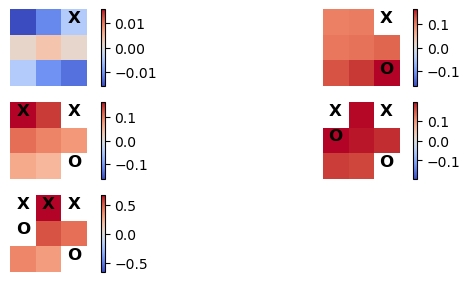

In [56]:
game.play_game_show_Q()

## Robot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd
import pickle

import robot

In [2]:
 class Experiment:

    def __init__(self, environment, agent):

        self.env = environment
        self.agent = agent

    def train(self, parms, verbose=True):

        n_batches = parms['n_batches']
        n_steps_per_batch = parms['n_steps_per_batch']
        n_epochs = parms['n_epochs']
        method = parms['method']
        learning_rate = parms['learning_rate']
        epsilon = parms['initial_epsilon']
        final_epsilon = parms['final_epsilon']
        gamma = parms['gamma']

        env = self.env

        epsilon_decay =  np.exp((np.log(final_epsilon) - np.log(epsilon))/ (n_batches)) # to produce this final value

        epsilon_trace = []
        outcomes = []

        for batch in range(n_batches):
            agent.clear_samples()
            env.initialize()

            sum_rs = 0
            
            for step in range(n_steps_per_batch):

                obs = self.env.observe()
                action = agent.epsilon_greedy(epsilon)

                env.act(action)
                r = env.reinforcement()
                sum_rs += r

                done = step == n_steps_per_batch - 1
                agent.add_sample(obs, action, r, done)

            outcomes.append(sum_rs / n_steps_per_batch)

            self.agent.train(n_epochs, method, learning_rate, gamma)

            epsilon_trace.append(epsilon)
            epsilon *= epsilon_decay

            if verbose and (len(outcomes) % (n_batches // 20) == 0):
                print(f'{len(outcomes)}/{n_batches} batches, {np.mean(outcomes):.4f} outcome mean')

        if verbose:
            plt.figure(1)
            plt.clf()
            plt.subplot(2, 1, 1)
            n_per = 10
            n_bins = len(outcomes) // n_per
            outcomes_binned = np.array(outcomes).reshape(-1, n_per)
            avgs = outcomes_binned.mean(1)
            xs = np.linspace(n_per, n_per * n_bins, len(avgs))
            plt.plot(xs, avgs)
            plt.axhline(y=0, color='orange', ls='--')
            plt.ylabel('R')
    
            plt.subplot(2, 1, 2)
            plt.plot(epsilon_trace)
            plt.ylabel(r'$\epsilon$')
            #plt.pause(0.1)

        return outcomes # , epsilon_trace

    def test(self, n_trials, n_steps, epsilon=0.0, graphics=True):
        if graphics:
            fig = plt.figure(figsize=(10, 10))
        robot = self.env
        sum_rs = 0
        for trial in range(n_trials):
            robot.initialize()
            agent = self.agent
            points = np.zeros((n_steps, robot.n_links + 1, 2))
            actions = np.zeros((n_steps, robot.n_links))
            Q_values = np.zeros((n_steps))
    
            for i in range(n_steps):
                action = agent.epsilon_greedy(epsilon)
                Q = agent.use(np.hstack((robot.observe(), action)))
                self.env.act(action)
                sum_rs += self.env.reinforcement()
                points[i] = robot.points
                actions[i] = action
                Q_values[i] = Q[0, 0]
    
            if graphics:
                Q_min, Q_max = np.min(Q_values), np.max(Q_values)
                print(Q_min, Q_max)
                for i in range(n_steps):
                    fig.clf()
                    plt.scatter(robot.goal[0], robot.goal[1], s=40, c='blue')
                    action = actions[i]
                    robot.set_points(points[i])
                    robot.draw()  # alpha=(Q_values[i] - Q_min) / (Q_max - Q_min))
                    clear_output(wait=True)
                    display(fig)
    
                clear_output(wait=True)
        return sum_rs / (n_trials * n_steps)

In [7]:
robbie = robot.Robot()
robbie.set_goal([5., 5.])

agent = robot.QnetAgent(robbie, [100, 100, 100])
experiment = Experiment(robbie, agent)

In [11]:
import pandas as pd

previous_best = -np.inf

results = []
for nb in [100, 200, 5000]:
    for ns in [50, 100]:
        for ne in [5, 10]:
            for nh in [ [], [50], [50, 50] ]:
                parms = {
                    'n_batches': nb,
                    'n_steps_per_batch': ns,
                    'n_epochs': ne,
                    'method': 'scg',
                    'learning_rate': 0.01,
                    'initial_epsilon': 1.0,
                    'final_epsilon': 0.001,
                    'gamma': 1.0
                }
                agent = robot.QnetAgent(robbie, nh)
                experiment = Experiment(robbie, agent)
    
                outcomes = experiment.train(parms, verbose=False)
                results.append([nh, nb, ns, ne, outcomes[-1]])
                clear_output()
                df = pd.DataFrame(results, 
                                  columns=('hiddens', 'batches', 'steps', 
                                           'epochs', 'dist'))
                print(df.sort_values(by='dist', ascending=False))
                
                if outcomes[-1] > previous_best:
                    previous_best = outcomes[-1]
                    with open('best_robot_agent.pkl', 'wb') as f:
                        pickle.dump(agent, f)
                        
                print()

     hiddens  batches  steps  epochs       dist
13      [50]      200     50       5  -1.814330
17  [50, 50]      200     50      10  -4.569909
1       [50]      100     50       5  -5.063843
16      [50]      200     50      10  -5.805537
5   [50, 50]      100     50      10  -5.866438
4       [50]      100     50      10  -7.114635
18        []      200    100       5  -7.848883
7       [50]      100    100       5  -7.996590
6         []      100    100       5  -8.317250
0         []      100     50       5  -8.321376
3         []      100     50      10  -8.546975
10      [50]      100    100      10  -8.749536
12        []      200     50       5  -8.816075
2   [50, 50]      100     50       5  -8.881165
15        []      200     50      10  -9.246151
9         []      100    100      10  -9.302054
11  [50, 50]      100    100      10 -10.096282
8   [50, 50]      100    100       5 -10.254745
14  [50, 50]      200     50       5 -10.688630



KeyboardInterrupt: 

In [12]:
with open('best_robot_agent.pkl', 'rb') as f:
    agent = pickle.load(f)

robbie = agent.env
experiment = Experiment(robbie, agent)

mean_r = experiment.test(n_trials=10, n_steps=100, epsilon=0.0, graphics=False)

print(f'mean of reinforcements {mean_r:.3f}')

mean of reinforcements -2.424


25/500 batches, -7.9906 outcome mean
50/500 batches, -7.8550 outcome mean
75/500 batches, -7.6936 outcome mean
100/500 batches, -7.4452 outcome mean
125/500 batches, -7.2722 outcome mean
150/500 batches, -7.0897 outcome mean
175/500 batches, -6.8215 outcome mean
200/500 batches, -6.7659 outcome mean
225/500 batches, -6.6292 outcome mean
250/500 batches, -6.4414 outcome mean
275/500 batches, -6.2562 outcome mean
300/500 batches, -6.1209 outcome mean
325/500 batches, -5.9951 outcome mean
350/500 batches, -5.9060 outcome mean
375/500 batches, -5.8354 outcome mean
400/500 batches, -5.7448 outcome mean
425/500 batches, -5.6290 outcome mean
450/500 batches, -5.5753 outcome mean
475/500 batches, -5.5057 outcome mean
500/500 batches, -5.4142 outcome mean


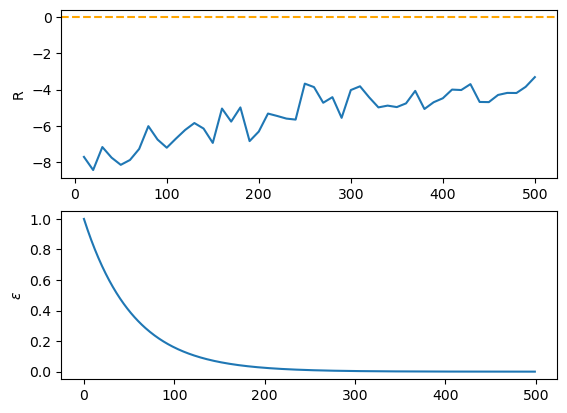

In [15]:
parms = {
    'n_batches': 500,
    'n_steps_per_batch': 50,  
    'n_epochs': 5,
    'method': 'scg',
    'learning_rate': 0.01,
    'initial_epsilon': 1.0,
    'final_epsilon': 0.0001,
    'gamma': 1.0
}

agent = robot.QnetAgent(robbie, [50])
experiment = Experiment(robbie, agent)

outcomes = experiment.train(parms)

-3.4894459784287455

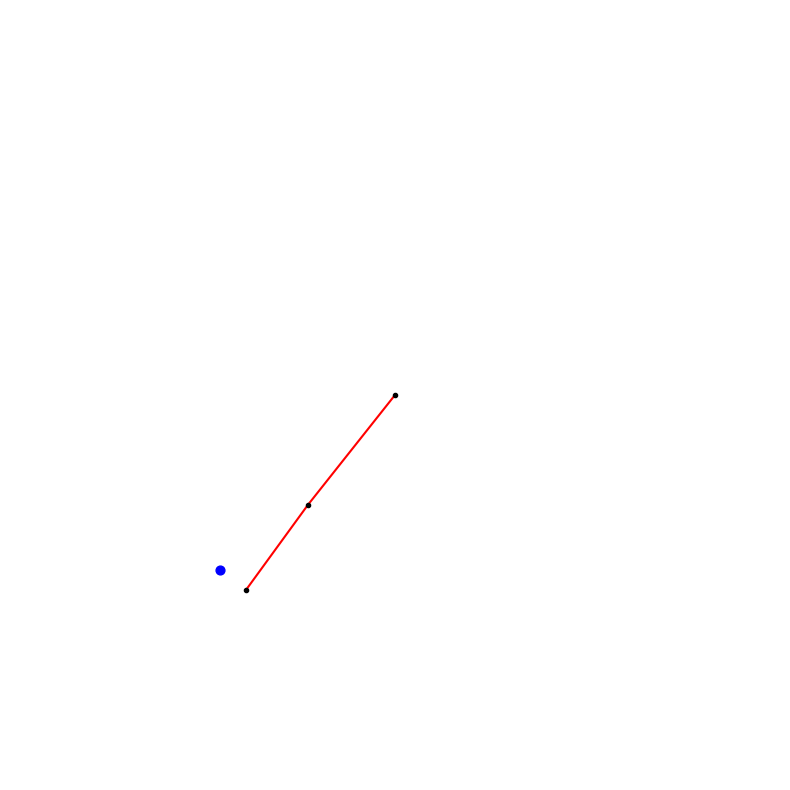

In [16]:
experiment.test(10, 100, epsilon=0.0, graphics=True)